In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from scipy import stats
from common import load_data, pareto_rank
import os
import json
from pathlib import Path
from collections import namedtuple
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import fpgrowth, fpmax

import itertools

In [2]:
data_dir = Path("../data")
random_state = 1234
test_size = 0.2

Data = namedtuple(
    "Data",
    [
        "perf_matrix",
        "input_features",
        "config_features",
        "all_performances",
        "input_preprocessor",
        "config_preprocessor",
    ],
)

# TODO Pareto front cut-off parameter

systems = json.load(open(data_dir / "metadata.json")).keys()

front_ratio = []
baseline_results = []
all_data = {}

for s in systems:
    (
        perf_matrix,
        input_features,
        config_features,
        all_performances,
        input_preprocessor,
        config_preprocessor,
    ) = load_data(system=s, data_dir="../data")
    all_data[s] = Data(
        perf_matrix,
        input_features,
        config_features,
        all_performances,
        input_preprocessor,
        config_preprocessor,
    )

In [80]:
adfs = []
for s in systems:
    print(s)
    print(all_data[s].perf_matrix[all_data[s].all_performances].corr())
    print("")
    adf = all_data[s].perf_matrix[all_data[s].all_performances].corr().unstack().reset_index().rename(columns={"level_0": "x", "level_1": "y", 0: "value"}).round(2)
    adf["system"] = s
    adfs.append(adf)
    # (
    #     p9.ggplot(adf, p9.aes("x", "y", fill="value"))
    #     + p9.geom_tile(p9.aes(width=0.95, height=0.95))
    #     + p9.geom_text(p9.aes(label="value"), size=9)
    #     + p9.scale_fill_cmap()
    #     + p9.scale_y_discrete(limits=sorted(adf.x.unique().tolist(), reverse=True))
    #     + p9.theme(
    #         axis_ticks=p9.element_blank(),
    #         panel_background=p9.element_rect(fill="white"),
    #     )
    #     + p9.labs(x="", y="")
    # ).save(f"{s}-correlation.pdf")

gcc
           size     ctime      exec
size   1.000000  0.719241 -0.003158
ctime  0.719241  1.000000 -0.045461
exec  -0.003158 -0.045461  1.000000

imagemagick
          size      time
size  1.000000  0.649383
time  0.649383  1.000000

lingeling
            conflicts       cps  reductions
conflicts    1.000000  0.991987    0.966871
cps          0.991987  1.000000    0.960334
reductions   0.966871  0.960334    1.000000

nodejs
     ops
ops  1.0

poppler
          size      time
size  1.000000  0.565525
time  0.565525  1.000000

sqlite
           q1        q2        q3        q4        q5        q6        q7  \
q1   1.000000  0.974107  0.999312  0.997606  0.998575  0.998432  0.999695   
q2   0.974107  1.000000  0.979779  0.986397  0.968957  0.983482  0.973575   
q3   0.999312  0.979779  1.000000  0.999239  0.997175  0.999699  0.999296   
q4   0.997606  0.986397  0.999239  1.000000  0.994738  0.999738  0.997556   
q5   0.998575  0.968957  0.997175  0.994738  1.000000  0.995684  0.998682 

In [81]:
adf = pd.concat(adfs)
adf

,x,y,value,system
0,size,size,1.00,gcc
1,size,ctime,0.72,gcc
2,size,exec,-0.00,gcc
3,ctime,size,0.72,gcc
4,ctime,ctime,1.00,gcc
...,...,...,...,...
35,kbs,kbs,1.00,x264
0,size,size,1.00,xz
1,size,time,0.79,xz
2,time,size,0.79,xz


In [90]:
(
    p9.ggplot(adf, p9.aes("x", "y", fill="value"))
    + p9.geom_tile(p9.aes(width=0.95, height=0.95))
    + p9.geom_text(p9.aes(label="value"), size=9)
    + p9.scale_fill_cmap()
    + p9.theme(
        axis_ticks=p9.element_blank(),
        panel_background=p9.element_rect(fill="white"),
        figure_size=(16,8)
    )
    + p9.labs(x="", y="")
    + p9.facet_wrap("system", scales="free", ncol=4)
).save("correlations.pdf", dpi=600)

/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 16 x 8 in image.
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: correlations.pdf


gcc
imagemagick
lingeling
nodejs
poppler
sqlite
x264
xz


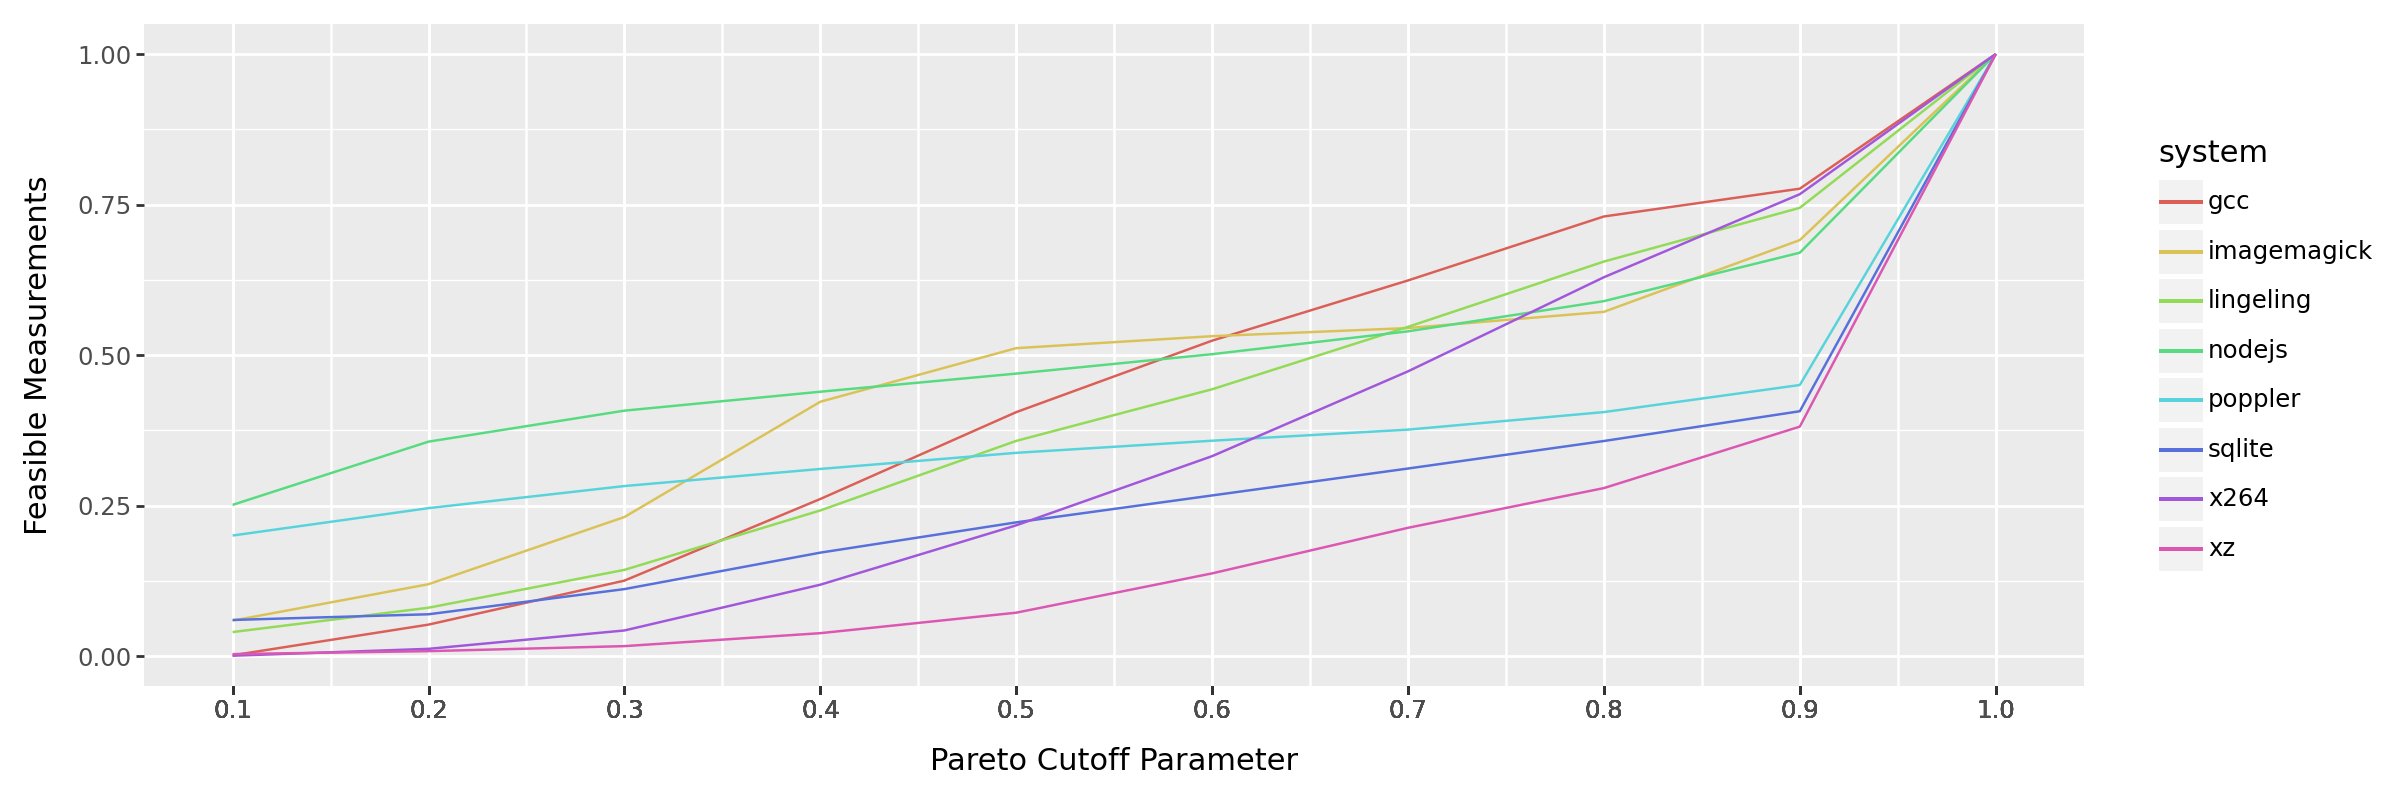

In [24]:
# Plot: Size of the Pareto fronts/configuration per cutoff parameter from 0.1..1.0
front_size = []

for s in systems:
    print(s)
    normalized_metrics = (
        all_data[s].perf_matrix[["inputname"] + all_data[s].all_performances]
        .groupby("inputname", as_index=False)
        .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    )

    for i in range(1, 11):
        performance_cutoff = 0.1 * i
        rem_measurements = (normalized_metrics <= performance_cutoff).all(axis=1).sum()
        front_size.append((s, round(performance_cutoff, 1), rem_measurements/normalized_metrics.shape[0]))

front_size_df = pd.DataFrame(front_size, columns=["system", "cutoff", "measurements"]) #.round(1)
(
    p9.ggplot(front_size_df, p9.aes(x="cutoff", y="measurements", color="system"))
    + p9.geom_line()
    + p9.scale_x_continuous(breaks=front_size_df.cutoff, labels=front_size_df.cutoff)
    + p9.theme(
        # axis_ticks=p9.element_blank(),
        # panel_background=p9.element_rect(fill="white"),
        figure_size=(12,4)
    )
    + p9.labs(x="Pareto Cutoff Parameter", y="Feasible Measurements")
) #.save("cutoff-size.pdf", dpi=600)

In [7]:
for s in systems:
    print(s)
    performances = all_data[s].all_performances
    icm = (
        all_data[s].perf_matrix[["inputname", "configurationID"] + performances]
        .sort_values(["inputname", "configurationID"])
        .set_index(["inputname", "configurationID"])
    )
    icm_ranked_measures = icm.groupby(
        "inputname"
    ).transform(  # Go from measured values to ranks within each input group
        lambda x: stats.rankdata(x, method="min")
    )

    icm["ranks"] = icm.groupby("inputname", group_keys=False).apply(pareto_rank)

    icr = icm.reset_index()
    icr[["configurationID", "ranks"]].groupby("configurationID").agg(["mean", "std"])

    mean_ranks = icr.groupby('configurationID')['ranks'].mean().sort_values()

    # Create a new ordered categorical variable for configurationID
    icr['configurationID_ordered'] = pd.Categorical(icr['configurationID'], categories=mean_ranks.index, ordered=True)

    # Creating the plot with the ordered configurationID
    (
        p9.ggplot(icr, p9.aes(x='configurationID_ordered', y='inputname', fill='ranks'))
        + p9.geom_tile(color='white', size=0.05)
        # + p9.scale_fill_cmap('plasma')
        + p9.scale_fill_cmap()
        + p9.theme(
            # axis_ticks=p9.element_blank(),
            # panel_background=p9.element_rect(fill="white"),
            figure_size=(12, 8)
        )
    ).save(f"{s}-ranks.pdf", dpi=400)

x264


/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 12 x 8 in image.
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: x264-ranks.pdf
